<a href="https://colab.research.google.com/github/sayan0506/DIscriminative-Learning-in-Semantic-Segmentation-on-Cityscape-Dataset/blob/main/Pretrained_Resnet_18_with_Discriminative_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modules import**

In [17]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from tqdm.notebook import tqdm

import numpy as np
import os
import copy
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans

# for unzipping
import zipfile

# this makes pyplot in interactive mode
plt.ion()

# Checking GPU utilization

* Before runing this notebook select runtime to GPU as following in Colab
> **Runtime -> Change runtime type -> Hardware acccelerator -> GPU**

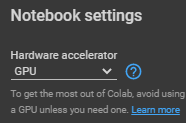

In [11]:
# checks whether, it's using cuda else  CPU(if gpu not available)
# if cuda is available device = cuda:0, else cpu will be allocated
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

print(f'Allocated device {device}')

Allocated device cuda:0


# **Loading the Cityscape imagepairs dataset from Kaggle**

Get multiple target image and label pairs

**Steps to download the dataset in collab**

1. Go to kaggle account, scroll to **API section**, and Click **Expire API Token** to remove previous tokens
2. Click on **Create New API Token**, it will download **kaggle.json** file on the machine
3. Go to google collab project notebook and run following commands in code shell


* Install Kaggle dependencies

In [3]:
# install the dependencies
!pip install kaggle

* import google.colab.files
* files.upload
* Choose the downloaded **kaggle.json**, and upload into collab

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayanhazra05","key":"038235153b6e88572467ff31dbc34db3"}'}

* Run to create new directory named kaggle
>**!mkdir -p ~/.kaggle**
* Run this to copy kaggle.json into the directory
>**!cp kaggle.json ~/.kaggle/** 
* Run this to change the permission
>**!chmod 600 ~/.kaggle/kaggle.json** 

In [5]:
# create kaggle directory
!mkdir -p ~/.kaggle
# copy kaggle,json in the directory
!cp kaggle.json ~/.kaggle/

# change the permission
!chmod 600 ~/.kaggle/kaggle.json

* **Download the dataset**(follow general steps or run the command for now)
* Go to kaggle, search the competition, here **"Cityscapes Image Pairs"**, open it, navigate to marked section for selection


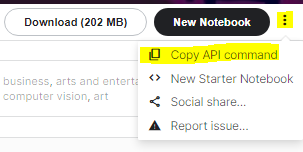

* **Click on copy API command**, for this Cityscapes dataset run the following
>**!kaggle datasets download -d dansbecker/cityscapes-image-pairs**
* **Note:** If normal download does not work, uncomment and run the folllowing to force download
>**!kaggle datasets download --force dansbecker/cityscapes-image-pairs** 
* Download the zip file named **"cityscapes-image-pairs.zip"**

In [6]:
# download the dataset
!kaggle datasets download --force dansbecker/cityscapes-image-pairs

# force download if normal download does not work
#!kaggle datasets download --force dansbecker/cityscapes-image-pairs 

 97% 195M/202M [00:02<00:00, 79.8MB/s]
100% 202M/202M [00:02<00:00, 80.7MB/s]


# Data Preperation

## Unzipping

In [9]:
if not os.path.isdir('/content/Cityscape'):
  os.mkdir('/content/Cityscape')


# path of zip
path_to_zip = '/content/cityscapes-image-pairs.zip'
# directory to which unzipped 
unzip_dir = '/content/Cityscape'

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
  zip_ref.extractall(unzip_dir)

## Data Inspection

Each image dimension
> height = 256
>
> width = 512(original= 256, segmented = 256)
>
> channels = 3(RGB)

In [18]:
# cityscape data directory
data_dir = '/content/Cityscape/cityscapes_data'

# train directory
train_dir = os.path.join(data_dir, 'train')

# validation directory
val_dir = os.path.join(data_dir, 'val')

print(f'Train directory {train_dir}\nValidation directory {val_dir}\n')

# train, validation samples list
train_samples, validation_samples = os.listdir(train_dir), os.listdir(val_dir)
print(f'Total Training image pairs {len(train_samples)}\nTotal Validation image pairs {len(validation_samples)}\n')

print(f'Sample image shape {np.array(Image.open(os.path.join(train_dir, train_samples[0]))).shape}')

Train directory /content/Cityscape/cityscapes_data/train
Validation directory /content/Cityscape/cityscapes_data/val

Total Training image pairs 2975
Total Validation image pairs 500

Sample image shape (256, 512, 3)


**Sample Visualization**

Visualizing 3 sample images in a row for train and valid set

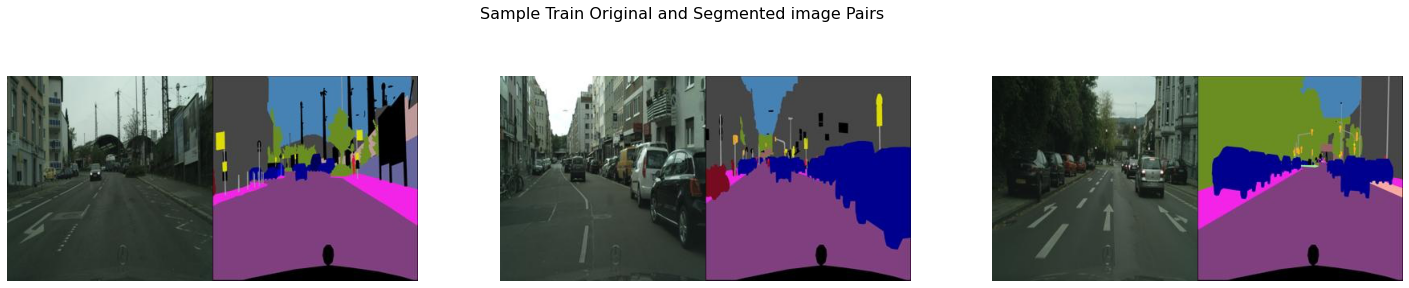

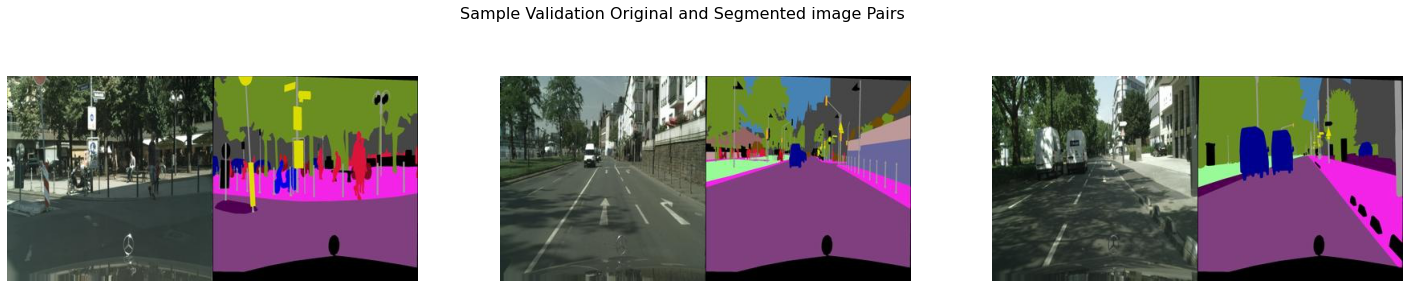

In [19]:
def img_vis(lst=None,title=None):
  
  path, img_list= lst
  # defining pyplot figure
  fig = plt.figure(figsize=(25,5))
  fig.suptitle(title, fontsize = 16)
  for i in range(3):
    sample = Image.open(os.path.join(path, img_list[i])).convert('RGB')
    fig.add_subplot(1,3,i+1)
    plt.imshow(sample)
    plt.axis('off')
  plt.show()
    

# fig_title list
title = ['Sample Train Original and Segmented image Pairs', 'Sample Validation Original and Segmented image Pairs']
#directory list
dir_list = [train_dir, val_dir]
# image list
img_list = [train_samples, validation_samples]
for i, lst in enumerate(zip(dir_list, img_list)):
  img_vis(lst = lst, title = title[i])



**Splitting images into Original and Segmented image**

Cityscape images are input, segmentation result as output image

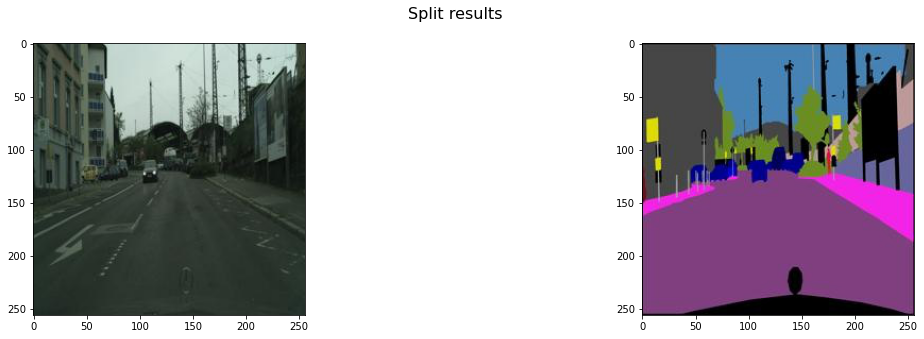

In [20]:
# split function
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:,:256,:], image[:,256:,]
  return cityscape, label

cityscape, label = split_image(Image.open(os.path.join(train_dir, train_samples[0])))

# axes is the object for fig list, instead of fig.add_subplot(1,2,img_count)
# we use axes[0], axes[1] here to access imshow
fig, axes = plt.subplots(1,2,figsize = (20,5))
fig.suptitle('Split results', fontsize = (16))

# Image.fromarray(img) converts the numpy array to PIL Image format "<class 'PIL.Image.Image'>""
axes[0].imshow(Image.fromarray(cityscape))
axes[1].imshow(Image.fromarray(label))

plt.show()

## Defining Labels

**Target type = "Color Space"**

Labels will be defined based on the color array or color variations in the segented labelled samples

In [21]:
# number of items in color array 1000(each corresponds to unique set of RGB intensity values)
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(f'Shape of color array {color_array.shape}')
print(f'First 5 elemnts in the color array {color_array[:5,:]}')

Shape of color array (1000, 3)
First 5 elemnts in the color array [[ 13  72  12]
 [226 150 184]
 [ 21 107  82]
 [237  30 166]
 [119 124  23]]


A label_model will be built using KMeans to cluster 10 classes from the color space

In [22]:
num_classes = 10

# label model using KMeans
label_model = KMeans(n_clusters= num_classes)
label_model.fit(color_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [23]:
print(f'First 5 elements of color space clusters prediction \n{label_model.predict(color_array[:5,:])}')

First 5 elements of color space clusters prediction 
[4 6 4 9 8]


**Clustered results**

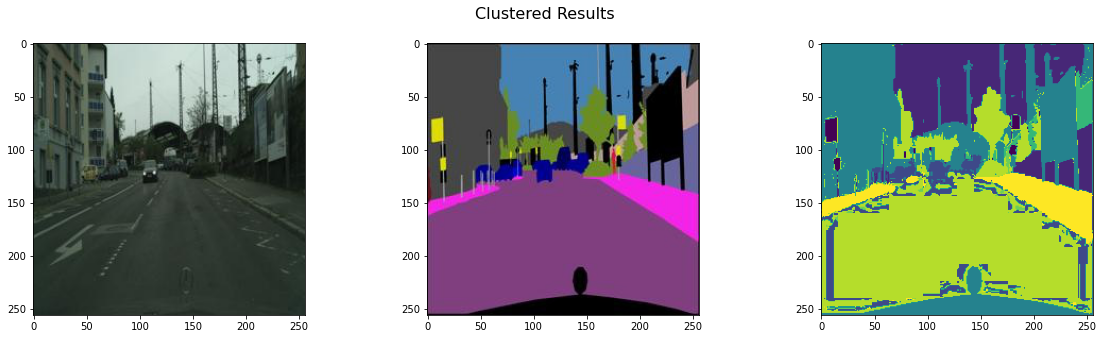

In [33]:
cityscape, label = split_image(Image.open(os.path.join(train_dir, train_samples[0])))
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)

# axes is the object for fig list, instead of fig.add_subplot(1,2,img_count)
# we use axes[0], axes[1] here to access imshow
fig, axes = plt.subplots(1,3,figsize = (20,5))
fig.suptitle('Clustered Results', fontsize = (16))

# Image.fromarray(img) converts the numpy array to PIL Image format "<class 'PIL.Image.Image'>""
axes[0].imshow(Image.fromarray(cityscape))
axes[1].imshow(Image.fromarray(label))
axes[2].imshow(label_class)

plt.show()

## Defining dataset using Pytorch 

Based on label model, the color_array clusters, the dataset will be segregated to various classes

In [25]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model
 
  # double underscore on both side helps it to be callable with the len function of Dataset abstract class
  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert('RGB')
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    cityscape = self.transform(cityscape)
    label_class = torch.Tensor(label_class).long()
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:,:256,:], image[:,256:,]
    return cityscape, label
  
  def transform(self, image):
    transform_ops = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean = (0.485, 0.456, 0.406), 
                                                             std = (0.229,0.224,0.225))])
    return transform_ops(image)


**Train Dataset**

In [38]:
dataset = CityscapeDataset(train_dir, label_model)
print(f'Length of the dataset {len(dataset)}')

# sample representation of dataset
cityscape, label_class = dataset[0]
print(f'Shape of input and output label {cityscape.shape, label_class.shape}')

Length of the dataset 2975
Shape of input and output label (torch.Size([3, 256, 256]), torch.Size([256, 256]))


**Train Dataloader**

In [53]:
# Batch size of the training
batch_size = 16

data_loader = DataLoader(dataset, batch_size = batch_size)
print(f'Length of dataloader {len(data_loader)}')

x, y = iter(data_loader).next()
print(f'Input, Label shape of the dataloader {x.shape, y.shape}')

Length of dataloader 186
Input, Label shape of the dataloader (torch.Size([16, 3, 256, 256]), torch.Size([16, 256, 256]))


#**Defining the Model using Pre-trained Resnet18**

In [48]:
# Resnet18 model
class Resnet18(nn.Module):

  def __init__(self, n_class):
    super().__init__()
    self.n_class = n_class
    self.model = models.resnet18(pretrained= True)
    for param in self.model.parameters():
      param.requires_grad = False
    self.relu = nn.ReLU(inplace = True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride = 2, padding= 1, dilation = 1, output_padding= 1)
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride = 2, padding= 1, dilation = 1, output_padding= 1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride = 2, padding= 1, dilation = 1, output_padding= 1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride = 2, padding= 1, dilation = 1, output_padding= 1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride = 2, padding= 1, dilation = 1, output_padding= 1)
    self.bn5 = nn.BatchNorm2d(32)
    self.classifier = nn.Conv2d(32, self.n_class, kernel_size= 1)

  def forward(self, x):
    # forward function for the rest of encoder

    x = self.model.relu(self.model.bn1(self.model.conv1(x)))
    x = self.model.maxpool(x)
    x = self.model.layer1(x)
    x = self.model.layer2(x)
    x = self.model.layer3(x)
    out_encoder = self.model.layer4(x)

    # forward function for decoder section
    x = self.bn1(self.relu(self.deconv1(out_encoder)))

    x = self.bn2(self.relu(self.deconv2(x)))
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    out_decoder = self.bn5(self.relu(self.deconv5(x)))
    score = self.classifier(out_decoder)

    return score


**Creating Model instant for Resnet18**

In [49]:
model = Resnet18(n_class=num_classes)

**Model Building Check**

In [50]:
Y_pred = model(x)
print(f'Predicted label shape {Y_pred.shape}')

Predicted label shape torch.Size([4, 10, 256, 256])


# **Model Training**

Training the model with following hyperparameters

>Batch size = 16
>
>Epochs = 15(as Recommended)
>
>Learning rate = 0.01  

In [52]:
# epochs
epochs = 15
# learning_rate 
lr = 0.01

**Loading the model to Device or GPU (cuda: 0)**

In [54]:
model = Resnet18(n_class= num_classes).to(device)

**Defining the cost function, optimizer**

In [55]:
# cost function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

**Defining the training loop**

In [56]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for x, y in tqdm(data_loader, total = len(data_loader), leave = False):
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader)) 

## **Training History Visualization**

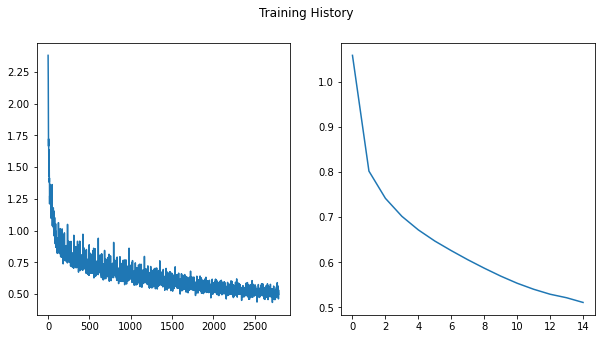

In [57]:
# defining step and epoch losses 
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Training History')

# step loss
axes[0].plot(step_losses)
# epoch loss
axes[1].plot(epoch_losses)

# Save Trained Model

Trained model weights and bias, dictionary are saved in 
**'Resnet18.pth'** file

In [58]:
model_name = 'Resnet18.pth'
torch.save(model.state_dict(), model_name)

# **Check Model Prediction without Discriminative Learning**

## **Load Saved model**

In [61]:
# enter the saved Resnet18.pth file path to load trained model weights, biases dictionary
model_path = '/content/Resnet18.pth'
model_ = Resnet18(n_class = num_classes).to(device)

print(f'Saved Model loading check result {model_.load_state_dict(torch.load(model_path))}')


Saved Model loading check result <All keys matched successfully>


## **Defining Test Dataset and Test Dataloader**



**Creating Validation Dataset**

In [62]:
# test mini batch size
test_batch_size = 8
# building test dataset
test_dataset = CityscapeDataset(val_dir, label_model)

**Building Test Datloader object**

In [64]:
test_data_loader = DataLoader(test_dataset, batch_size = test_batch_size)

**Checking Model output with test_dataloader before prediction**

In [66]:
# loading the test cityscape, labels iterativey
test_x, test_y = next(iter(test_data_loader))
# loading the test cityscape, labels to dataloader
test_x, test_y = test_x.to(device), test_y.to(device)

test_y_pred = model_(test_x)
print(f'Predicted result shape {test_y_pred.shape}')
test_y_pred = torch.argmax(test_y_pred, dim = 1)
print(f'Modified shape {test_y_pred.shape}')

Predicted result shape torch.Size([8, 10, 256, 256])
Modified shape torch.Size([8, 256, 256])


**Inverse Transform**

In [67]:
inverse_transform = transforms.Compose([transforms.Normalize(
    (-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)
)
])

# **Visualizing Prediction Result**

Predicted Result


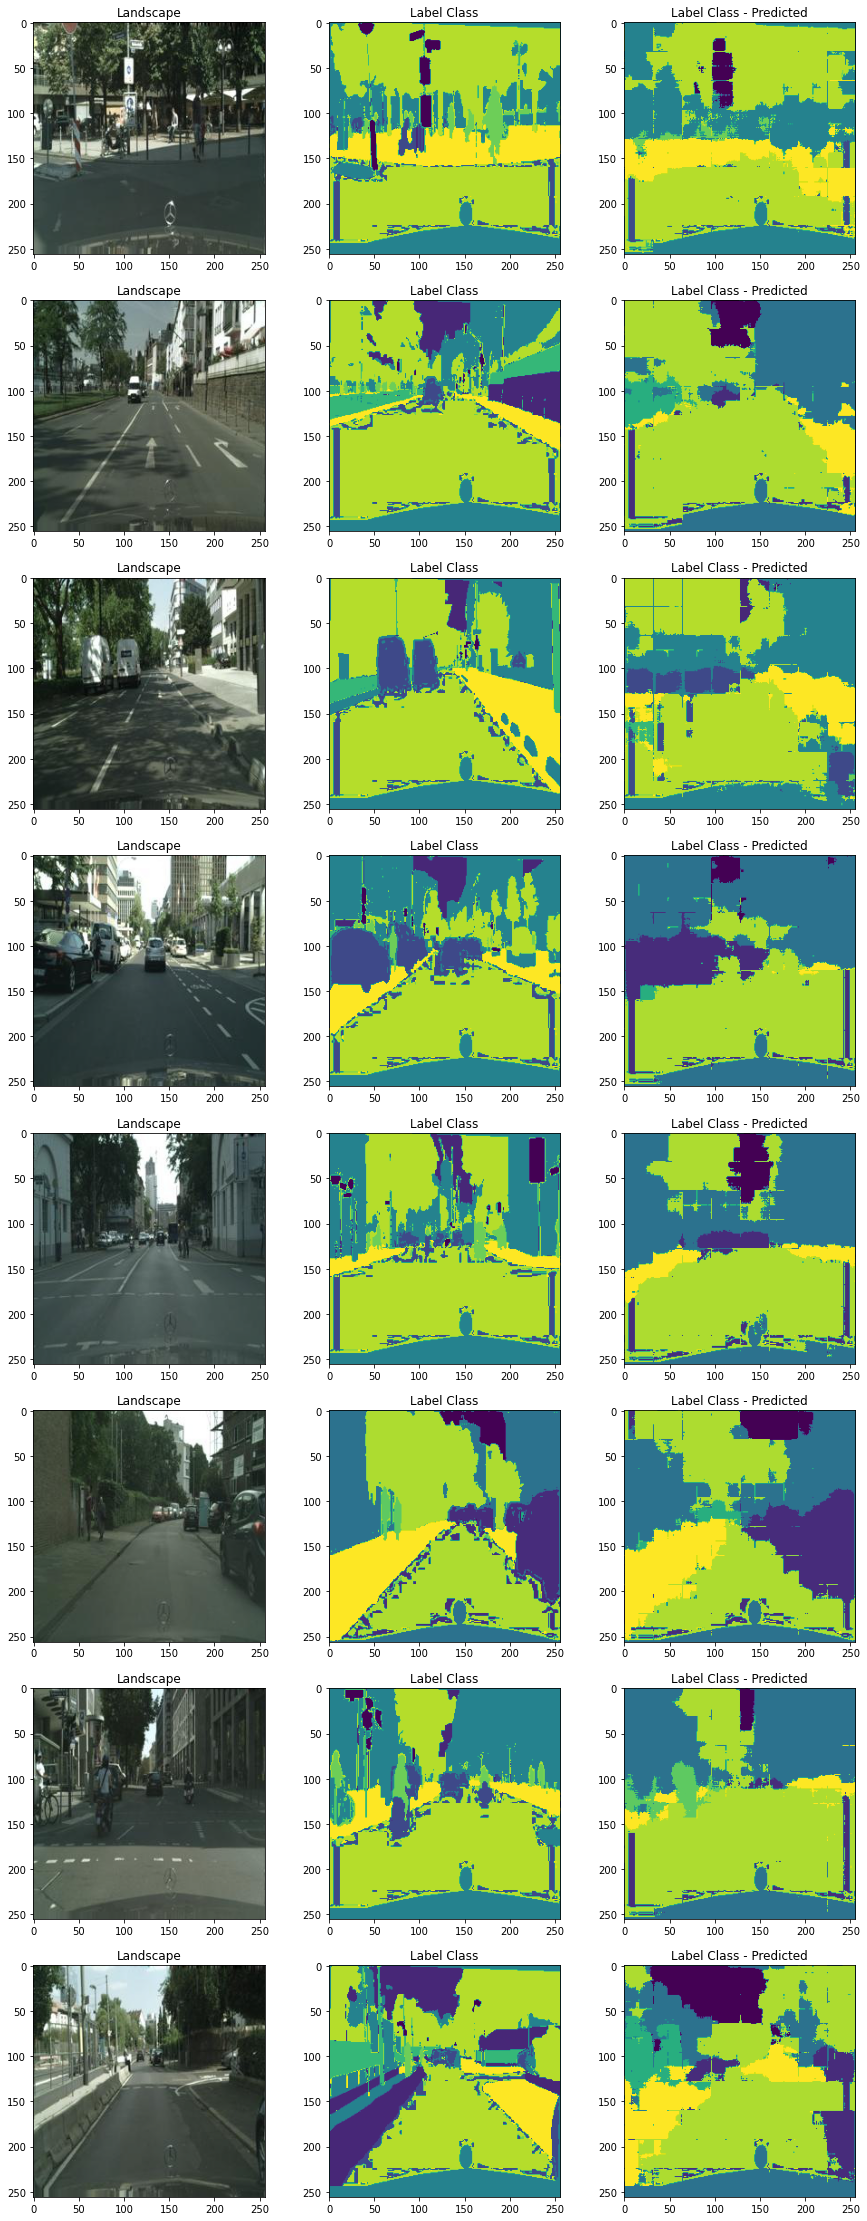

In [75]:
print('Predicted Result')

fig, axes = plt.subplots(test_batch_size, 3, figsize = (3*5, test_batch_size* 5))

for i in range(test_batch_size):
  landscape = inverse_transform(test_x[i]).permute(1,2,0).cpu().detach().numpy()
  label_class = test_y[i].cpu().detach().numpy()
  label_class_predicted = test_y_pred[i].cpu().detach().numpy()
  plt.imshow(label_class_predicted)
  
  axes[i, 0].imshow(landscape)
  axes[i, 0].set_title('Landscape')
  axes[i, 1].imshow(label_class)
  axes[i, 1].set_title('Label Class')
  axes[i, 2].imshow(label_class_predicted)
  axes[i, 2].set_title('Label Class - Predicted')
  